# Binary Image Classification

**Author:- Himanshu Atri**

*dataset link:-https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset*

A cat or dog detection model leverages convolutional neural networks (CNNs) to classify images as either a cat or a dog. The model is trained on a labeled dataset of cat and dog images, allowing it to learn and identify distinguishing features. Once trained, the model can accurately predict whether a new image contains a cat or a dog.

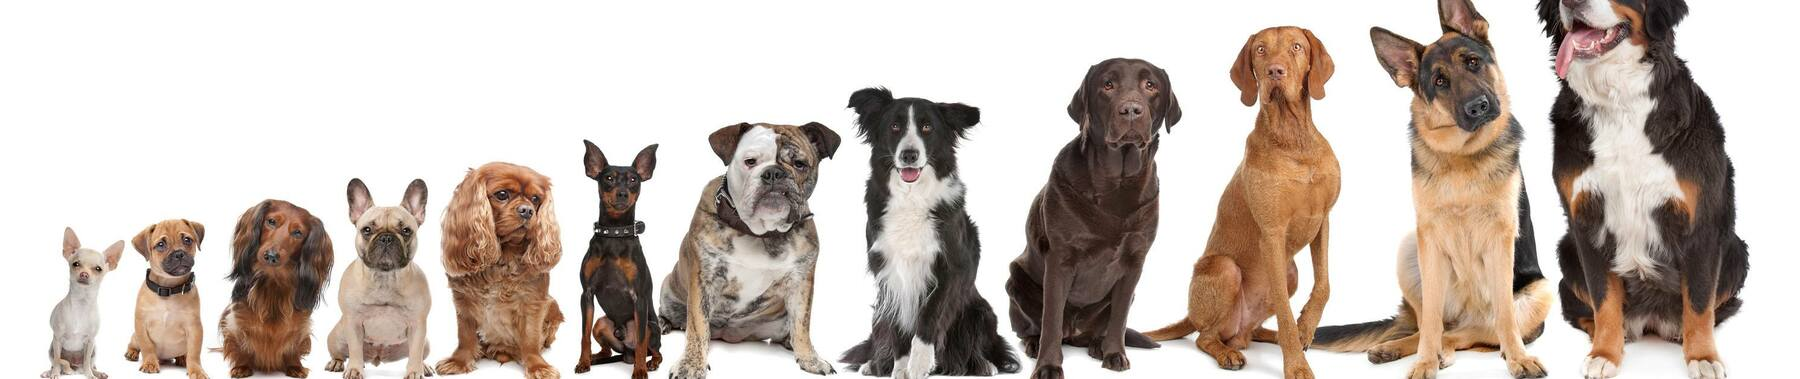

# Import Necessary Libraries

In [2]:
import os
import imghdr
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow  import keras
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from keras import Sequential
from tensorflow.keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Rescaling, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
from google.colab import drive

# Downloading the Dataset

In [3]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other
100% 785M/788M [00:42<00:00, 17.1MB/s]
100% 788M/788M [00:42<00:00, 19.4MB/s]


In [4]:
# @title Unzipping the data

!unzip /content/microsoft-catsvsdogs-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/Dog/550.jpg   
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  

# Defining paths

In [5]:
dir = '/content/PetImages'

In [6]:
cat_dir = '/content/PetImages/Cat'
dog_dir = '/content/PetImages/Dog'

# Understanding the data

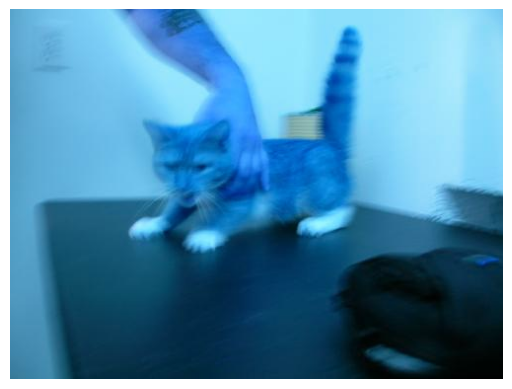

In [7]:
temp = cv2.imread('/content/PetImages/Cat/0.jpg')
plt.axis("off")
plt.imshow(temp)

In [8]:
cat_files = os.listdir('/content/PetImages/Cat')
dog_files = os.listdir('/content/PetImages/Dog')

print(f"Cats picture count: {len(cat_files)}\nDogs picture count: {len(dog_files)} ")

Cats picture count: 12501
Dogs picture count: 12501 


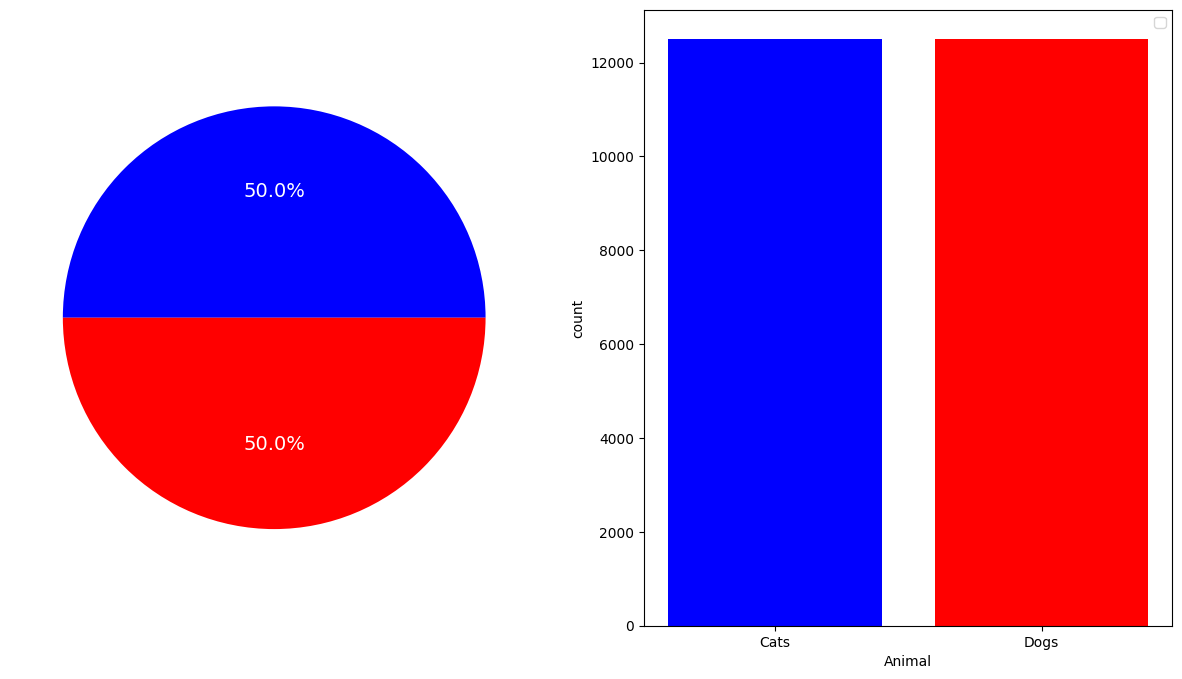

In [9]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.pie([len(cat_files), len(dog_files)], labels=['Cats', 'Dogs'], colors = ['blue', 'red'], autopct='%1.1f%%', textprops={'fontsize': 14, 'color': 'white'})
plt.subplot(1, 2, 2)
plt.bar(['Cats', 'Dogs'], [len(cat_files), len(dog_files)], color = ['blue', 'red'])
plt.xlabel('Animal')
plt.ylabel('count')

plt.legend()
plt.show()

# Data Cleaning and Proccessing

In [10]:
# label dictionary
dict_labels={'Cat':0,'Dog':1}

In [11]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/PetImages'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)


Image not in ext list /content/PetImages/Dog/9967.jpg
Image not in ext list /content/PetImages/Dog/9145.jpg
Image not in ext list /content/PetImages/Dog/9961.jpg
Image not in ext list /content/PetImages/Dog/8521.jpg
Image not in ext list /content/PetImages/Dog/2905.jpg
Image not in ext list /content/PetImages/Dog/1259.jpg
Image not in ext list /content/PetImages/Dog/8730.jpg
Image not in ext list /content/PetImages/Dog/7459.jpg
Image not in ext list /content/PetImages/Dog/4203.jpg
Image not in ext list /content/PetImages/Dog/8194.jpg
Image not in ext list /content/PetImages/Dog/2317.jpg
Image not in ext list /content/PetImages/Dog/7083.jpg
Image not in ext list /content/PetImages/Dog/10678.jpg
Image not in ext list /content/PetImages/Dog/719.jpg
Image not in ext list /content/PetImages/Dog/7652.jpg
Image not in ext list /content/PetImages/Dog/6059.jpg
Image not in ext list /content/PetImages/Dog/2877.jpg
Image not in ext list /content/PetImages/Dog/6555.jpg
Image not in ext list /conte

In [12]:
cat_files = os.listdir('/content/PetImages/Cat')
dog_files = os.listdir('/content/PetImages/Dog')

print(f"Cats picture count: {len(cat_files)}\nDogs picture count: {len(dog_files)} ")

Cats picture count: 12385
Dogs picture count: 12353 


In [13]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [14]:
# Training generator
train_generator = datagen.flow_from_directory(
    '/content/PetImages',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',

    subset='training'
)

# Validation generator
validation_generator = datagen.flow_from_directory(
    '/content/PetImages',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 19791 images belonging to 2 classes.
Found 4947 images belonging to 2 classes.


# CNN Architecture

In [15]:
model = Sequential()
model.add(Input(shape=(224, 224, 3)))

model.add(Conv2D(32, kernel_size=(3,3), padding='valid',activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(64, kernel_size=(3,3), padding='valid',activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(128, kernel_size=(3,3), padding='valid',activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(256, kernel_size=(3,3), padding='valid',activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# model.add(Conv2D(512, kernel_size=(3,3), padding='valid',activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.1))
# model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))


model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
path = '/content/catVsdogs.keras'

model_checkpoint = ModelCheckpoint(
filepath=path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch',
)

model_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True,
    start_from_epoch=1
)

# Training the Model

In [18]:
result = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[model_checkpoint, model_early_stopping]
)


Epoch 1/50
338/619 [===============>..............] - ETA: 24s - loss: 1.7676 - accuracy: 0.5589

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


619/619 [==============================] - ETA: 0s - loss: 1.4541 - accuracy: 0.5920
Epoch 1: val_loss improved from inf to 0.98991, saving model to /content/catVsdogs.keras
619/619 [==============================] - 86s 122ms/step - loss: 1.4541 - accuracy: 0.5920 - val_loss: 0.9899 - val_accuracy: 0.6446
Epoch 2/50
619/619 [==============================] - ETA: 0s - loss: 0.7882 - accuracy: 0.7292
Epoch 2: val_loss improved from 0.98991 to 0.75614, saving model to /content/catVsdogs.keras
619/619 [==============================] - 64s 103ms/step - loss: 0.7882 - accuracy: 0.7292 - val_loss: 0.7561 - val_accuracy: 0.6756
Epoch 3/50
619/619 [==============================] - ETA: 0s - loss: 0.5491 - accuracy: 0.7986
Epoch 3: val_loss improved from 0.75614 to 0.53649, saving model to /content/catVsdogs.keras
619/619 [==============================] - 75s 121ms/step - loss: 0.5491 - accuracy: 0.7986 - val_loss: 0.5365 - val_accuracy: 0.7922
Epoch 4/50
619/619 [==========================

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 64)      256       
 chNormalization)                                                
                                                        

# Accuracy and Loss Graph

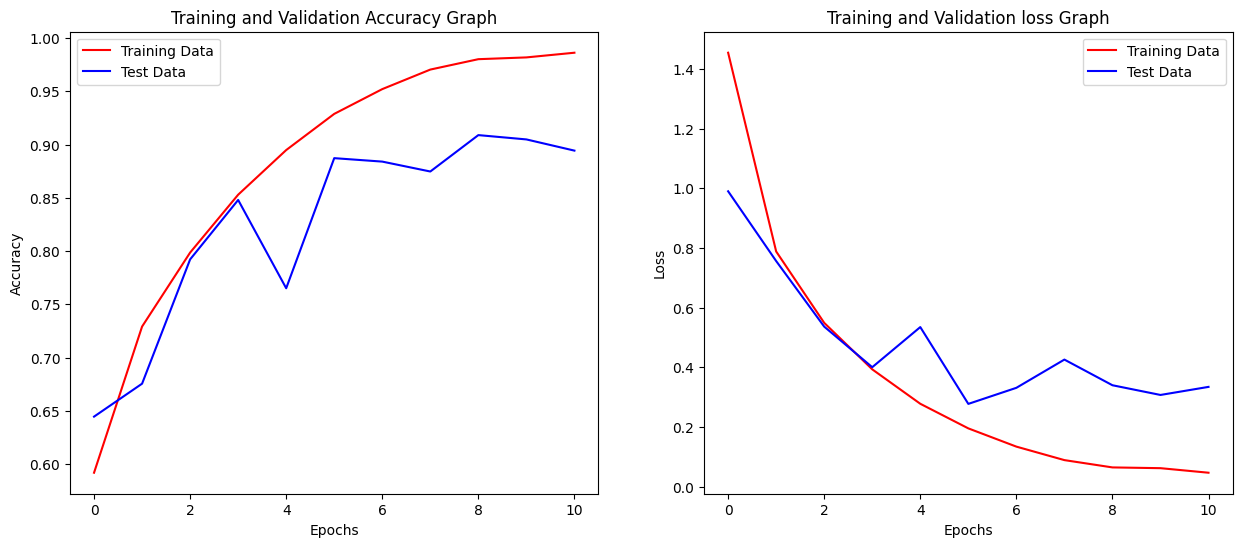

In [20]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.plot(result.history['accuracy'], color='r', label="Training Data")
plt.plot(result.history['val_accuracy'], color='b', label="Test Data")
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy Graph")

plt.subplot(1,2,2)
plt.plot(result.history['loss'], color='r', label="Training Data")
plt.plot(result.history['val_loss'], color='b', label="Test Data")
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation loss Graph")

plt.show()

# Evaluating the Model

In [67]:
test_ds = []
label_ds = []
dog_rand_ind = np.random.choice(range(0, len(dog_files)), size=1000, replace=False)
cat_rand_ind = np.random.choice(range(0, len(cat_files)), size=1000, replace=False)
for dog_ind, cat_ind in zip(dog_rand_ind, cat_rand_ind):
  #for dog
  dog_img_name = dog_files[dog_ind]
  dog_img_path = os.path.join(dir, 'Dog', dog_img_name)
  dog_img = cv2.imread(dog_img_path)
  dog_img = cv2.resize(dog_img, (224, 224))
  dog_img = dog_img/255.0
  test_ds.append(dog_img)
  label_ds.append(1)

  #for cat
  cat_img_name = cat_files[cat_ind]
  cat_img_path = os.path.join(dir, 'Cat', cat_img_name)
  cat_img = cv2.imread(cat_img_path)
  cat_img = cv2.resize(cat_img, (224, 224))
  cat_img = cat_img/255.0
  test_ds.append(cat_img)
  label_ds.append(0)

test_ds = np.array(test_ds, dtype=np.float32)
label_ds = np.array(label_ds, dtype=np.int32)
test_ds.shape, label_ds.shape

((2000, 224, 224, 3), (2000,))

In [68]:
predictions = model.predict(test_ds)

63/63 [==============================] - 2s 25ms/step


In [69]:
# Extract predicted labels from the prediction
prediction_list = []

for pred in predictions:
    prediction_list.append(int(np.round(pred[0])))

prediction_list = np.array(prediction_list, dtype=np.int32)
prediction_list.shape

(2000,)

In [71]:
# Generate the classification report
report = classification_report(label_ds, prediction_list, target_names=['Cat', 'Dog'])
print(report)

              precision    recall  f1-score   support

         Cat       0.88      0.94      0.91      1000
         Dog       0.93      0.87      0.90      1000

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.90      2000
weighted avg       0.91      0.91      0.90      2000



# Testing on individual Images

In [25]:
def predict_animal(img_path):
    img = cv2.imread(img_path)
    img_resize = cv2.resize(img, (224, 224))
    img_resize = np.array(img_resize, dtype=np.float32)
    img_resize /= 255.0
    img_input = img_resize.reshape(1, 224, 224, 3)
    prediction = model.predict(img_input)

    if prediction[0][0] > 0.5:
        title = "It's a dog."
    else:
        title = "It's a cat."

    plt.figure(figsize=(3, 2))
    plt.axis("off")
    plt.title(title)
    plt.imshow(img)

1/1 [==============================] - 0s 432ms/step


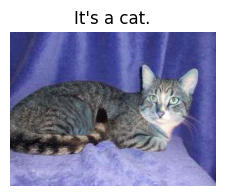

In [26]:
predict_animal("/content/PetImages/Cat/10004.jpg")

1/1 [==============================] - 0s 18ms/step


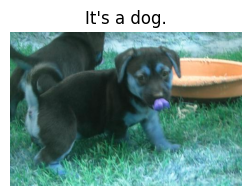

In [27]:
predict_animal("/content/PetImages/Dog/3204.jpg")

1/1 [==============================] - 0s 21ms/step


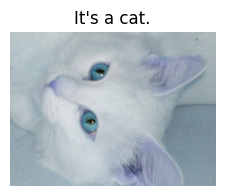

In [28]:
predict_animal("/content/PetImages/Cat/9876.jpg")

1/1 [==============================] - 0s 19ms/step


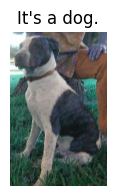

In [29]:
predict_animal("/content/PetImages/Dog/7853.jpg")

1/1 [==============================] - 0s 22ms/step


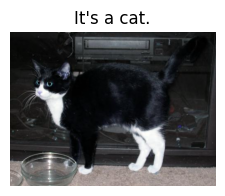

In [30]:
predict_animal("/content/PetImages/Cat/321.jpg")

1/1 [==============================] - 0s 27ms/step


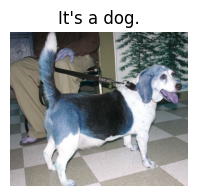

In [31]:
predict_animal("/content/PetImages/Dog/9898.jpg")

1/1 [==============================] - 0s 18ms/step


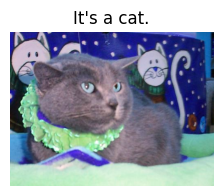

In [32]:
predict_animal("/content/PetImages/Cat/8989.jpg")

# Uploading the model on drive

In [33]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:

# Define the path where you want to save the model in your Google Drive
model_save_path = '/content/drive/MyDrive/Image_classification/catVsdogs.keras'

# Save your trained model to the specified path
model.save(model_save_path)

In [35]:
# Unmount Google Drive
drive.flush_and_unmount()